In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.parser import parse

import seaborn as sns
sns.set()

%matplotlib inline


In [2]:
#Data directories
popdir = 'C:\\Users\\mlamherr\\Data'
savedir = 'C:\\Users\\mlamherr\\Data'

In [3]:
ba2016 = pd.read_csv(savedir + "/" + 'BA_2016.csv', index_col='UTC Time', parse_dates =True )

In [4]:
#Bus areas 1-16 in numerical order as case10K file
WA = ['AVA', 'BPAT','CHPD','DOPD','GCPD','PSEI','SCL','TPWR','AVA', 'BPAT']
OR = ['BPAT','GRID','IPCO','PACW','PGE']
CAnorth = ['BANC','CISO','PACW','BPAT']
CABayArea = ['CISO']
CAcentral = ['CISO', 'TIDC']
CAsw = ['CISO', 'LDWP']
CAse = ['CISO', 'IID']
NV = ['NEVP']
AZ = ['AZPS','DEAA','GRIF','GRMA','HGMA','PNM','SRP','TEPC','WALC']
UT = ['PACE']
NM = ['EPE','PNM']
CO = ['PSCO','WACM']
WY = ['PACE','WACM']
ID = ['AVA','BPAT','IPCO','PACE']
MT = ['BPAT','GWA','NWMT','WAUW','WWA'] 
ElPaso = ['EPE']

BA_all = sorted(list(set().union(WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso)))

In [5]:
Northern_California = ['Butte','Colusa','Del Norte','El Dorado','Glenn','Humboldt',
                       'Lake','Lassen','Mendocino','Modoc','Nevada','Placer','Plumas',
                       'Sacramento','Shasta','Sierra','Siskiyou','Sutter','Tehama',
                       'Trinity','Yolo','Yuba']
Bay_Area = ['Alameda','Contra Costa','Marin','Napa','San Francisco','San Mateo',
            'Santa Clara','Santa Cruz','Solano','Sonoma']
Central_California = ['Alpine','Amador','Calaveras','Fresno','Inyo','Kings','Madera',
                      'Mariposa','Merced','Mono','Monterey','San Benito','San Joaquin',
                      'Stanislaus','Tulare','Tuolumne']
Southeast_California = ['Imperial','Orange','Riverside','San Bernardino','San Diego']
Southwest_California = ['Kern','Los Angeles','San Luis Obispo','Santa Barbara','Ventura']

CA = [Northern_California, Bay_Area, Central_California, Southeast_California, Southwest_California]
CAnames = ['Northern_California', 'Bay_Area', 'Central_California', 'Southeast_California', 'Southwest_California']
CA_all = Northern_California + Bay_Area + Central_California + Southeast_California +Southwest_California
CA_union = list(set().union(Northern_California, Bay_Area, Central_California, Southeast_California, Southwest_California))
shortCAnames = ['CAnorth','CABayArea','CAcentral','CAsw','CAse']

numCounties = 0
for x in zip(CAnames,CA):
    print('There are '+ str(len(x[1])) + ' counties in region ' + x[0])
    numCounties = numCounties + len(x[1])
print('There are ' + str(numCounties) + ' total counties in California.')


There are 22 counties in region Northern_California
There are 10 counties in region Bay_Area
There are 16 counties in region Central_California
There are 5 counties in region Southeast_California
There are 5 counties in region Southwest_California
There are 58 total counties in California.


In [6]:
# CA regions: get populations of demand regions

CA_population_file = 'Web_ACS2016_Pop-Race.xlsx'
df = pd.read_excel(io = popdir + "/" + CA_population_file, sheet_name='Total Pop & Median Age', skiprows=[0,1,2,3,4])


In [7]:
df.head()

,Geography,Estimate,Margin of Error,Estimate.1,Margin of Error.1,Unnamed: 5,Summary Level,County,Place
0,California,39250017,*****,36.4,0.2,NaN,40,NaN,NaN
1,Alameda County,1647704,*****,37.4,0.2,NaN,50,1.0,NaN
2,Alameda city,78907,29,42.2,2.1,NaN,160,1.0,562.0
3,Berkeley city,121241,34,32.1,1.6,NaN,160,1.0,6000.0
4,Castro Valley CDP,65153,4863,43.1,2.9,NaN,160,1.0,11964.0


In [8]:
df.columns

Index(['Geography', 'Estimate', 'Margin of Error', 'Estimate.1',
       'Margin of Error.1', 'Unnamed: 5', 'Summary Level', 'County', 'Place'],
      dtype='object')

In [9]:
df.drop(columns =['Margin of Error', 'Estimate.1',
       'Margin of Error.1', 'Unnamed: 5', 'Summary Level', 'County', 'Place'], inplace=True)

In [10]:
df.head()

,Geography,Estimate
0,California,39250017
1,Alameda County,1647704
2,Alameda city,78907
3,Berkeley city,121241
4,Castro Valley CDP,65153


In [11]:
counties = df.loc[df['Geography'].str.contains('County')][['Geography','Estimate']]
counties = counties.reset_index(drop=True)

In [12]:
counties['Geography'] = counties['Geography'].str.replace(' County','')
counties.head()

,Geography,Estimate
0,Alameda,1647704
1,Butte,226864
2,Contra Costa,1135127
3,El Dorado,185625
4,Fresno,979915


Some counties do not have population data (from this source) because they have less than 65000 residents. There are total of 58 counties but only 40 have >65000 in 2016.

In [13]:
intersection = set(counties['Geography']) & set(pd.Series(CA_union))
union = set(counties['Geography']) | set(pd.Series(CA_union))
print('These 18 counties in CA have no population data')
print(set(union - intersection))  ## counties with < 65000 in 2016
print()
print('Counties with missing population data are in Northern and Central CA. ')

These 18 counties in CA have no population data
{'Siskiyou', 'Amador', 'Trinity', 'San Benito', 'Alpine', 'Lassen', 'Tuolumne', 'Plumas', 'Del Norte', 'Modoc', 'Sierra', 'Calaveras', 'Inyo', 'Mono', 'Glenn', 'Mariposa', 'Colusa', 'Tehama'}

Counties with missing population data are in Northern and Central CA. 


In [14]:
#Dictionary for region population counts
popcount = {}
for i in zip(shortCAnames, CA):
    region_name = i[0]
    region_county_list = i[1]
    popcount[region_name] = counties[counties['Geography'].isin(region_county_list)]['Estimate'].sum()
  

In [15]:
popcount

{'CAnorth': 3262336,
 'CABayArea': 7958684,
 'CAcentral': 3724007,
 'CAsw': 11199001,
 'CAse': 12601498}

In [16]:
#Add other population data cut and paste from the sources mentioned above.
#To do: The US Census data is automatable; not about El Paso yet
popcount['WA']=7280934
popcount['OR']=4085989
popcount['NV']=2939254
popcount['AZ']=6908642
popcount['UT']=3044321
popcount['NM']=2085432
popcount['CO']=5530105
popcount['WY']=584910
popcount['ID']=1680026
popcount['MT']=1038656
popcount['ElPaso']=678058

In [17]:
popcount

{'CAnorth': 3262336,
 'CABayArea': 7958684,
 'CAcentral': 3724007,
 'CAsw': 11199001,
 'CAse': 12601498,
 'WA': 7280934,
 'OR': 4085989,
 'NV': 2939254,
 'AZ': 6908642,
 'UT': 3044321,
 'NM': 2085432,
 'CO': 5530105,
 'WY': 584910,
 'ID': 1680026,
 'MT': 1038656,
 'ElPaso': 678058}

In [18]:
ba2016.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='UTC Time', length=8784, freq=None)

In [19]:
ba2016.head()

,AVA,AZPS,BANC,BPAT,CHPD,CISO,DEAA,DOPD,EPE,GCPD,...,PSEI,SCL,SRP,TEPC,TIDC,TPWR,WACM,WALC,WAUW,WWA
UTC Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1789.0,2982.0,1909.0,7689.0,325.0,23745.0,NaN,256.0,848.0,540.0,...,4238.0,1411.0,2730.0,1624.0,245.0,732.0,3254.0,838.0,108.0,NaN
2016-01-01 01:00:00,1930.0,3363.0,2028.0,8143.0,353.0,24213.0,NaN,282.0,948.0,573.0,...,4712.0,1488.0,3026.0,1801.0,256.0,784.0,3472.0,904.0,123.0,NaN
2016-01-01 02:00:00,1991.0,3642.0,2271.0,8634.0,371.0,25174.0,NaN,298.0,988.0,592.0,...,5085.0,1588.0,3262.0,1788.0,284.0,839.0,3448.0,948.0,110.0,NaN
2016-01-01 03:00:00,1970.0,3615.0,2301.0,8598.0,366.0,28423.0,NaN,293.0,959.0,594.0,...,5030.0,1551.0,3220.0,1763.0,285.0,837.0,3417.0,937.0,115.0,NaN
2016-01-01 04:00:00,1905.0,3568.0,2242.0,8390.0,365.0,28784.0,NaN,294.0,929.0,593.0,...,4845.0,1484.0,3142.0,1739.0,276.0,816.0,3374.0,922.0,112.0,NaN


Some BAs don't have any data for 2016. -- Check with EIA.

In [20]:
ba2016.isnull().sum()

AVA        0
AZPS       0
BANC       0
BPAT       0
CHPD       0
CISO       0
DEAA    8784
DOPD      16
EPE        0
GCPD       0
GRID    8784
GRIF    8784
GRMA    8784
GWA     8784
HGMA    8784
IID        0
IPCO       0
LDWP       0
NEVP       0
NWMT       0
PACE       0
PACW       0
PGE        0
PNM        0
PSCO       0
PSEI       0
SCL        0
SRP        0
TEPC       0
TIDC       0
TPWR       0
WACM       0
WALC       0
WAUW      24
WWA     8784
dtype: int64

EIA already imputes data up to 24 hours, i.e., if there is more than 24 consecutive hours of missing data, it does not impute beyond the first 24 points.

In [21]:
#Replace NA with 0's
ba2016.fillna(0, inplace=True)
ba2016.isnull().sum()

AVA     0
AZPS    0
BANC    0
BPAT    0
CHPD    0
CISO    0
DEAA    0
DOPD    0
EPE     0
GCPD    0
GRID    0
GRIF    0
GRMA    0
GWA     0
HGMA    0
IID     0
IPCO    0
LDWP    0
NEVP    0
NWMT    0
PACE    0
PACW    0
PGE     0
PNM     0
PSCO    0
PSEI    0
SCL     0
SRP     0
TEPC    0
TIDC    0
TPWR    0
WACM    0
WALC    0
WAUW    0
WWA     0
dtype: int64

In [22]:
#Shared BAs
totalCISO = popcount['CAnorth'] + popcount['CABayArea'] + popcount['CAcentral'] + popcount['CAsw'] + popcount['CAse']
totalBPAT = popcount['WA'] + popcount['OR'] + popcount['CAnorth'] + popcount['ID'] + popcount['MT']
totalAVA = popcount['ID']+popcount['WA']
totalPACW = popcount['OR']+popcount['CAnorth']
totalIPCO = popcount['OR']+popcount['ID']
totalPNM =  popcount['AZ']+popcount['NM']
totalPACE = popcount['UT']+popcount['WY']+popcount['ID']
totalEPE = popcount['ElPaso']+popcount['NM']
totalWACM = popcount['WY']+popcount['CO']

In [23]:
# Define region BA demand counts. 
# If a BA is entirely in region, give  all of that BA's count to the region
# If a BA is shared with other regions. get the fraction corresponding to the population fraction for that region
# BA sharing is found in Balancing_Authorities_JAN2017.pdf

#In region order:
ba2016['WA'] = ba2016['SCL'] + ba2016['PSEI'] + ba2016['TPWR'] + ba2016['CHPD'] + ba2016['DOPD'] + ba2016['GCPD'] + \
                ba2016['AVA']*popcount['WA']/totalAVA + ba2016['BPAT']*popcount['WA']/totalBPAT

ba2016['OR'] = ba2016['PGE'] + ba2016['GRID'] + \
                ba2016['PACW']*popcount['OR']/totalPACW + \
                ba2016['BPAT']*popcount['OR']/totalBPAT + \
                ba2016['IPCO']*popcount['OR']/totalIPCO

ba2016['CAnorth'] = ba2016['BANC'] + \
                ba2016['PACW']*popcount['CAnorth']/totalPACW + \
                ba2016['BPAT']*popcount['CAnorth']/totalBPAT
                #ba2016['IPCO']*popcount['CAnorth']/totalIPCO
                
ba2016['CABayArea'] = ba2016['CISO']*popcount['CABayArea']/totalCISO

ba2016['CAcentral'] = ba2016['TIDC'] + ba2016['CISO']*popcount['CAcentral']/totalCISO

ba2016['CAsw'] = ba2016['LDWP'] + ba2016['CISO']*popcount['CAsw']/totalCISO

ba2016['CAse'] = ba2016['IID'] + ba2016['CISO']*popcount['CAse']/totalCISO

ba2016['NV'] = ba2016['NEVP']

ba2016['AZ'] = ba2016['WALC'] + ba2016['AZPS'] + ba2016['GRIF'] + ba2016['HGMA'] + \
                ba2016['DEAA'] + ba2016['GRMA'] + ba2016['SRP'] + ba2016['TEPC'] + \
                ba2016['PNM']*popcount['AZ']/totalPNM

ba2016['UT'] = ba2016['PACE']* popcount['UT']/totalPACE

ba2016['NM'] = ba2016['PNM']*popcount['NM']/totalPNM + ba2016['EPE']*popcount['NM']/totalEPE


ba2016['CO'] = ba2016['PSCO'] + ba2016['WACM']*popcount['CO']/totalWACM

ba2016['WY'] = ba2016['WACM']*popcount['WY']/totalWACM + ba2016['PACE']*popcount['WY']/totalPACE

ba2016['ID'] = ba2016['IPCO']*popcount['ID']/totalIPCO + \
                ba2016['AVA']*popcount['ID']/totalAVA + \
                ba2016['BPAT']*popcount['ID']/totalBPAT + \
                ba2016['PACE']*popcount['ID']/totalPACE

ba2016['MT'] = ba2016['WAUW'] + ba2016['NWMT'] + ba2016['WWA'] + ba2016['GWA'] + \
                ba2016['BPAT']*popcount['MT']/totalBPAT

ba2016['ElPaso'] = ba2016['EPE']*popcount['ElPaso']/totalEPE

In [24]:
ba2016.head()

,AVA,AZPS,BANC,BPAT,CHPD,CISO,DEAA,DOPD,EPE,GCPD,...,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
UTC Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1789.0,2982.0,1909.0,7689.0,325.0,23745.0,0.0,256.0,848.0,540.0,...,8038.764430,3910.0,9492.115647,3270.092720,1037.816589,8751.750209,939.537653,3485.741657,2054.355842,208.067764
2016-01-01 01:00:00,1930.0,3363.0,2028.0,8143.0,353.0,24213.0,0.0,282.0,948.0,573.0,...,8215.975580,4220.0,10561.901516,3537.869907,1158.494427,9484.898195,1011.838103,3757.820694,2198.537732,232.604056
2016-01-01 02:00:00,1991.0,3642.0,2271.0,8634.0,371.0,25174.0,0.0,298.0,988.0,592.0,...,8572.528817,4593.0,11150.916945,3597.503371,1201.664481,9430.193829,1020.999936,3873.025462,2223.934886,242.418574
2016-01-01 03:00:00,1970.0,3615.0,2301.0,8598.0,366.0,28423.0,0.0,293.0,959.0,594.0,...,9636.225453,4607.0,11025.177363,3391.079843,1173.519588,9202.159024,978.374277,3740.322659,2182.779494,235.303049
2016-01-01 04:00:00,1905.0,3568.0,2242.0,8390.0,365.0,28784.0,0.0,294.0,929.0,593.0,...,9748.636191,4523.0,10847.350976,3518.374352,1146.706864,8983.272036,998.718552,3766.586468,2130.326117,227.942161


In [25]:
ba2016.columns

Index(['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'DEAA', 'DOPD', 'EPE',
       'GCPD', 'GRID', 'GRIF', 'GRMA', 'GWA', 'HGMA', 'IID', 'IPCO', 'LDWP',
       'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO', 'PSEI', 'SCL',
       'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW', 'WWA', 'WA',
       'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV', 'AZ',
       'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

In [26]:
demand2016 = ba2016.drop(columns = ['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'DEAA',
       'DOPD', 'EPE', 'GCPD', 'GRID', 'GRIF', 'GRMA', 'GWA', 'HGMA', 'IID',
       'IPCO', 'LDWP', 'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO',
       'PSEI', 'SCL', 'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW',
       'WWA'])

In [27]:
demand2016.describe()

,WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,9577.067048,6407.425583,4175.545203,5402.610679,2823.021380,10857.845790,8971.947644,4148.422017,10866.974780,3046.670310,1101.942407,7509.732247,858.078925,3085.334701,1714.448692,234.598524
std,1592.682555,1060.619217,744.725536,988.021095,537.207333,2075.996816,1718.706294,1047.604833,2762.067378,423.856077,248.005160,1153.927677,110.012318,438.177110,231.648549,62.896107
min,6369.823319,4232.133898,2811.187977,3770.489617,1856.739981,7134.659643,6188.059544,2747.000000,6686.043117,1555.057243,360.785579,2955.115286,548.521415,2107.599396,1109.196855,0.000000
25%,8483.752686,5637.972439,3640.034714,4677.935712,2430.893301,9315.370227,7714.786430,3470.000000,8876.949281,2751.740305,931.687555,6736.373566,783.362758,2774.177635,1548.958623,190.156270
50%,9460.716479,6372.330284,4109.776987,5258.986731,2732.295099,10614.484638,8691.959092,3798.000000,9999.592504,3001.742134,1043.411708,7343.662943,844.189369,3034.954118,1699.207803,218.618370
75%,10515.224211,7067.802431,4562.563568,5821.037407,3041.798631,11750.307856,9690.097719,4436.000000,12077.449569,3264.358733,1200.658183,8078.226149,916.317084,3349.052559,1858.426253,260.084704
max,14994.678833,9871.664208,7275.399896,9449.846091,5039.747740,19426.169495,15954.551173,8525.000000,20897.867919,7164.616611,2031.505399,14633.472104,1630.120602,5431.386540,2503.464584,465.944202


In [28]:
demand2016.head()

,WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
UTC Time,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,12182.667947,7745.749151,4621.104822,4877.439310,2527.238889,9883.251224,8038.764430,3910.0,9492.115647,3270.092720,1037.816589,8751.750209,939.537653,3485.741657,2054.355842,208.067764
2016-01-01 01:00:00,13177.776753,8231.089657,4907.168959,4973.570773,2583.220477,10144.521874,8215.975580,4220.0,10561.901516,3537.869907,1158.494427,9484.898195,1011.838103,3757.820694,2198.537732,232.604056
2016-01-01 02:00:00,14014.413091,8800.997672,5357.931753,5170.968927,2703.586515,10794.289169,8572.528817,4593.0,11150.916945,3597.503371,1201.664481,9430.193829,1020.999936,3873.025462,2223.934886,242.418574
2016-01-01 03:00:00,13880.241023,8709.545581,5378.498099,5838.343125,3016.862537,11762.379640,9636.225453,4607.0,11025.177363,3391.079843,1173.519588,9202.159024,978.374277,3740.322659,2182.779494,235.303049
2016-01-01 04:00:00,13466.129768,8442.049274,5235.543433,5912.495813,3042.559873,11771.723025,9748.636191,4523.0,10847.350976,3518.374352,1146.706864,8983.272036,998.718552,3766.586468,2130.326117,227.942161


In [29]:
demand2016.tail()

,WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
UTC Time,,,,,,,,,,,,,,,,
2016-12-31 19:00:00,13307.310042,8217.926126,4865.776318,4892.023356,2538.063019,9753.773053,8068.856292,3757.0,9168.245280,3108.394290,991.973652,7604.228298,885.992200,3544.711600,2087.661125,196.781069
2016-12-31 20:00:00,13199.996164,8102.982134,4800.802566,4923.861768,2552.960767,9865.574230,8118.268105,3727.0,8999.925452,3053.921414,979.802753,7492.202173,870.552369,3474.180040,2040.363140,197.271795
2016-12-31 21:00:00,12939.035290,7915.328755,4635.527738,4909.483131,2545.232752,9895.341441,8089.501480,3706.0,8870.548524,2985.113572,966.860125,7394.463002,852.071385,3385.107167,1994.353091,193.591351
2016-12-31 22:00:00,12668.534354,7708.945926,4513.764735,4862.239035,2515.126416,9841.862275,8018.696855,3701.0,8799.722136,2971.925402,962.686513,7354.949940,847.050585,3342.935744,1957.893315,193.591351
2016-12-31 23:00:00,12584.238364,7659.967078,4449.550616,4823.622123,2491.056889,9790.522783,7954.552205,3707.0,8903.447442,3037.292852,962.905562,7484.080396,862.479275,3376.815288,1963.576131,190.646996


In [30]:
demand2016.describe()

,WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,9577.067048,6407.425583,4175.545203,5402.610679,2823.021380,10857.845790,8971.947644,4148.422017,10866.974780,3046.670310,1101.942407,7509.732247,858.078925,3085.334701,1714.448692,234.598524
std,1592.682555,1060.619217,744.725536,988.021095,537.207333,2075.996816,1718.706294,1047.604833,2762.067378,423.856077,248.005160,1153.927677,110.012318,438.177110,231.648549,62.896107
min,6369.823319,4232.133898,2811.187977,3770.489617,1856.739981,7134.659643,6188.059544,2747.000000,6686.043117,1555.057243,360.785579,2955.115286,548.521415,2107.599396,1109.196855,0.000000
25%,8483.752686,5637.972439,3640.034714,4677.935712,2430.893301,9315.370227,7714.786430,3470.000000,8876.949281,2751.740305,931.687555,6736.373566,783.362758,2774.177635,1548.958623,190.156270
50%,9460.716479,6372.330284,4109.776987,5258.986731,2732.295099,10614.484638,8691.959092,3798.000000,9999.592504,3001.742134,1043.411708,7343.662943,844.189369,3034.954118,1699.207803,218.618370
75%,10515.224211,7067.802431,4562.563568,5821.037407,3041.798631,11750.307856,9690.097719,4436.000000,12077.449569,3264.358733,1200.658183,8078.226149,916.317084,3349.052559,1858.426253,260.084704
max,14994.678833,9871.664208,7275.399896,9449.846091,5039.747740,19426.169495,15954.551173,8525.000000,20897.867919,7164.616611,2031.505399,14633.472104,1630.120602,5431.386540,2503.464584,465.944202


In [31]:
demand2016.columns

Index(['WA', 'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV',
       'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

In [32]:
popcount.keys()

dict_keys(['CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'WA', 'OR', 'NV', 'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'])

In [33]:
for region in ['WA', 'OR', 'NV', 'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT']:
    print(region, demand2016[region].sum(), demand2016[region].sum()/popcount[region], sep='\t')

WA	84124956.95201638	11.554143596414468
OR	56282826.3249444	13.774590760020255
NV	36439739.0	12.397614836962031
AZ	95455506.46989438	13.816826298119715
UT	26761952.002975747	8.790778634373888
NM	9679462.104279194	4.641466182680229
CO	65965488.054159306	11.928433195058558
WY	7537365.276872319	12.88636760676398
ID	27101580.01185475	16.13164320781628
MT	15059717.309967335	14.49923488620615


In [34]:
#Compare against EIA consumption per capita data
stateDemandEIA = pd.read_csv(savedir + "/" + 'Total Energy Consumed per Capita-StateRankings.csv')

In [35]:
stateDemandEIA.columns

Index(['Rank', 'State', 'Total Energy Consumed per Capita, million Btu',
       'Note: Rankings are based on the full source data values.'],
      dtype='object')

In [36]:
stateDemandEIA.drop(columns = ['Rank', 'Note: Rankings are based on the full source data values.'], 
                   inplace = True)

In [37]:
Mbtu_to_MWhr = 3.412
stateDemandEIA['yearly_demand_per_capita_MW-hr'] = \
    stateDemandEIA['Total Energy Consumed per Capita, million Btu'] / Mbtu_to_MWhr

In [38]:
stateDemandEIA

,State,"Total Energy Consumed per Capita, million Btu",yearly_demand_per_capita_MW-hr
0,LA,897,262.895662
1,WY,860,252.051583
2,AK,809,237.104338
3,ND,776,227.432591
4,IA,489,143.317702
5,TX,472,138.335287
6,NE,455,133.352872
7,SD,445,130.422040
8,IN,422,123.681125
9,WV,419,122.801876


In [39]:
popcount

{'CAnorth': 3262336,
 'CABayArea': 7958684,
 'CAcentral': 3724007,
 'CAsw': 11199001,
 'CAse': 12601498,
 'WA': 7280934,
 'OR': 4085989,
 'NV': 2939254,
 'AZ': 6908642,
 'UT': 3044321,
 'NM': 2085432,
 'CO': 5530105,
 'WY': 584910,
 'ID': 1680026,
 'MT': 1038656,
 'ElPaso': 678058}

In [40]:
demand2016.columns

Index(['WA', 'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV',
       'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

In [41]:
# Check #1: Given that GegnerPerCapita_MW is from peak demand data (and assuming that it hasn't changed between 2010 and 2016),
# check that total demand per year <= expected total demand and expected total peak demand ~ peak demand * 8784

wecc_regions = ['WA', 'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw',
       'CAse', 'NV', 'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso']

CA_regions = ['CAnorth', 'CABayArea', 'CAcentral', 'CAsw','CAse']

GegnerPerCapita_MW = 2.0e-3

total_demand= {}
total_peak = {}
expected_peak = {}
peak_diff = {}
peak_total_diff = {}
peak_total_ratio = {}
max_demand = {}
min_demand = {}

for r in wecc_regions:
    total_demand[r] = demand2016[r].sum()
    total_peak[r] = demand2016[r].max() * 8784.
    expected_peak[r] = popcount[r] * GegnerPerCapita_MW * 8784.
    peak_diff[r] = (expected_peak[r] - total_peak[r])*100./expected_peak[r]
    peak_total_diff[r] = (expected_peak[r] - total_demand[r])*100./expected_peak[r]
    peak_total_ratio[r] = expected_peak[r]/total_demand[r]
    max_demand[r] = demand2016[r].max()
    min_demand[r] = demand2016[r].min()

ds = [total_demand, total_peak, expected_peak, max_demand, min_demand, peak_diff, peak_total_diff, peak_total_ratio]

#Add CA
for x in ds:
    x['CA'] = sum(x[r] for r in CA_regions)


d = {}
for k in total_demand.keys():
    d[k] = tuple(d[k] for d in ds)
    
check1 = pd.DataFrame.from_dict(d, orient='index', columns=['total_demand', 'total_peak', 'expected_peak', 
                                                            'max_demand','min_demand',
                                                            'peak_diff','peak_total_diff','peak_total_ratio'])

In [42]:
check1.head(20)

,total_demand,total_peak,expected_peak,max_demand,min_demand,peak_diff,peak_total_diff,peak_total_ratio
WA,8.412496e+07,1.317133e+08,1.279114e+08,14994.678833,6369.823319,-2.972221,34.231878,1.520493
OR,5.628283e+07,8.671270e+07,7.178265e+07,9871.664208,4232.133898,-20.798957,21.592721,1.275392
CAnorth,3.667799e+07,6.390711e+07,5.731272e+07,7275.399896,2811.187977,-11.505987,36.003753,1.562592
CABayArea,4.745653e+07,8.300745e+07,1.398182e+08,9449.846091,3770.489617,40.631855,66.058392,2.946236
CAcentral,2.479742e+07,4.426914e+07,6.542335e+07,5039.747740,1856.739981,32.334341,62.096991,2.638313
CAsw,9.537532e+07,1.706395e+08,1.967440e+08,19426.169495,7134.659643,13.268293,51.523150,2.062840
CAse,7.880959e+07,1.401448e+08,2.213831e+08,15954.551173,6188.059544,36.695815,64.401265,2.809089
NV,3.643974e+07,7.488360e+07,5.163681e+07,8525.000000,2747.000000,-45.019791,29.430699,1.417047
AZ,9.545551e+07,1.835669e+08,1.213710e+08,20897.867919,6686.043117,-51.244397,21.352309,1.271493
UT,2.676195e+07,6.293399e+07,5.348263e+07,7164.616611,1555.057243,-17.671832,49.961415,1.998458


In [43]:
check1.head(20)

,total_demand,total_peak,expected_peak,max_demand,min_demand,peak_diff,peak_total_diff,peak_total_ratio
WA,8.412496e+07,1.317133e+08,1.279114e+08,14994.678833,6369.823319,-2.972221,34.231878,1.520493
OR,5.628283e+07,8.671270e+07,7.178265e+07,9871.664208,4232.133898,-20.798957,21.592721,1.275392
CAnorth,3.667799e+07,6.390711e+07,5.731272e+07,7275.399896,2811.187977,-11.505987,36.003753,1.562592
CABayArea,4.745653e+07,8.300745e+07,1.398182e+08,9449.846091,3770.489617,40.631855,66.058392,2.946236
CAcentral,2.479742e+07,4.426914e+07,6.542335e+07,5039.747740,1856.739981,32.334341,62.096991,2.638313
CAsw,9.537532e+07,1.706395e+08,1.967440e+08,19426.169495,7134.659643,13.268293,51.523150,2.062840
CAse,7.880959e+07,1.401448e+08,2.213831e+08,15954.551173,6188.059544,36.695815,64.401265,2.809089
NV,3.643974e+07,7.488360e+07,5.163681e+07,8525.000000,2747.000000,-45.019791,29.430699,1.417047
AZ,9.545551e+07,1.835669e+08,1.213710e+08,20897.867919,6686.043117,-51.244397,21.352309,1.271493
UT,2.676195e+07,6.293399e+07,5.348263e+07,7164.616611,1555.057243,-17.671832,49.961415,1.998458


In [44]:
check1.to_csv(savedir + '/' +'demandCheckSummary.csv')

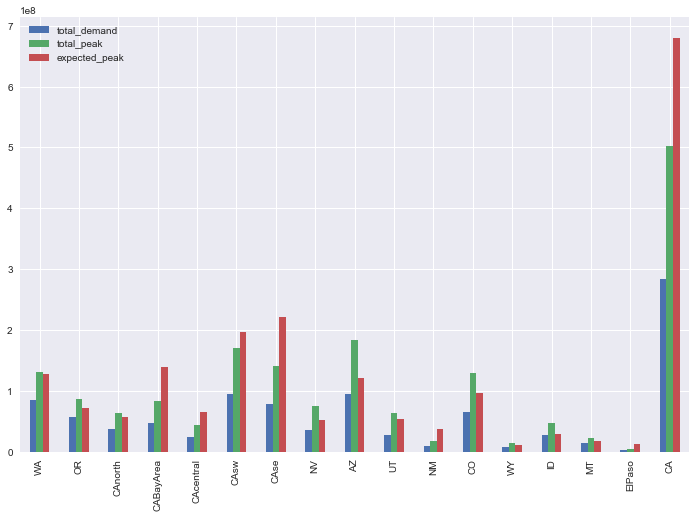

In [45]:
check1.plot.bar(y = ['total_demand', 'total_peak', 'expected_peak'], figsize = (12,8))

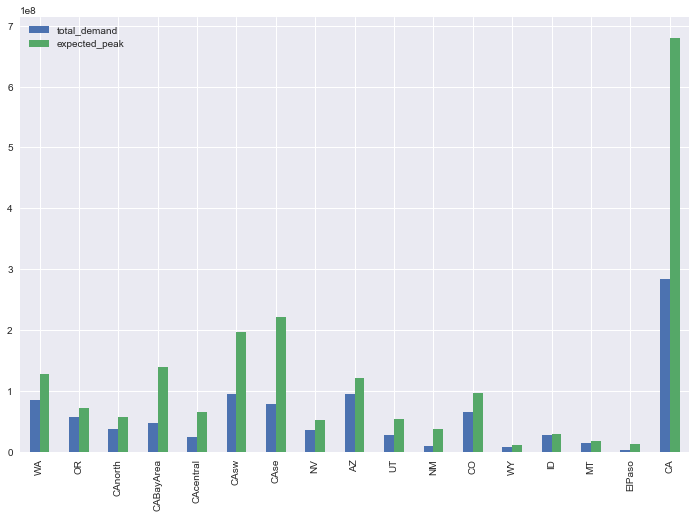

In [46]:
check1.plot.bar(y = ['total_demand', 'expected_peak'], figsize = (12,8))

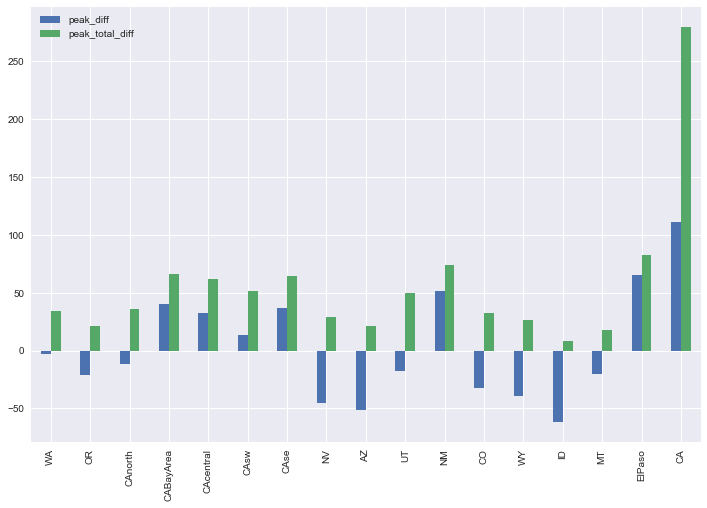

In [47]:
check1.plot.bar(y = ['peak_diff','peak_total_diff'],figsize = (12,8))
#Peak_total diffs are all > 0 -- GOOD
#Peak_diffs can be > 20% for some regions --- should this be a problem? But are max peaks used the right peaks? (Maybe they were imputed?)
#Note that there are 8 BA's that don't report demand:

In [48]:
ba2016.columns

Index(['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'DEAA', 'DOPD', 'EPE',
       'GCPD', 'GRID', 'GRIF', 'GRMA', 'GWA', 'HGMA', 'IID', 'IPCO', 'LDWP',
       'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO', 'PSEI', 'SCL',
       'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW', 'WWA', 'WA',
       'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV', 'AZ',
       'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

#### Review missing BA data

* DEAA,GRID, GRIF, GRMA, GWA,HGMA,WWA have missing data

* WA = ['AVA', 'BPAT','CHPD','DOPD','GCPD','PSEI','SCL','TPWR','AVA', 'BPAT']
* OR = ['BPAT','GRID','IPCO','PACW','PGE']
* CAnorth = ['BANC','CISO','PACW','BPAT']
* CABayArea = ['CISO']
* CAcentral = ['CISO', 'TIDC']
* CAsw = ['CISO', 'LDWP']
* CAse = ['CISO', 'IID']
* NV = ['NEVP']
* AZ = ['AZPS','DEAA','GRIF','GRMA','HGMA','PNM','SRP','TEPC','WALC']
* UT = ['PACE']
* NM = ['EPE','PNM']
* CO = ['PSCO','WACM']
* WY = ['PACE','WACM']
* ID = ['AVA','BPAT','IPCO','PACE']
* MT = ['BPAT','GWA','NWMT','WAUW','WWA'] 
* ElPaso = ['EPE']

So
* AZ, OR, MT have unreported demand

But generally, measured demand as calculated is within order of magnitude of peak expected -- may be good enough. 
One thing to check, if possible, is range of demand and population changes over the years and see calculated is within range.

In [49]:
ba2016.columns

Index(['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'DEAA', 'DOPD', 'EPE',
       'GCPD', 'GRID', 'GRIF', 'GRMA', 'GWA', 'HGMA', 'IID', 'IPCO', 'LDWP',
       'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO', 'PSEI', 'SCL',
       'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW', 'WWA', 'WA',
       'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV', 'AZ',
       'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

In [50]:
demand2016.columns

Index(['WA', 'OR', 'CAnorth', 'CABayArea', 'CAcentral', 'CAsw', 'CAse', 'NV',
       'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'ElPaso'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D52F9EA9B0>,
      dtype=object)

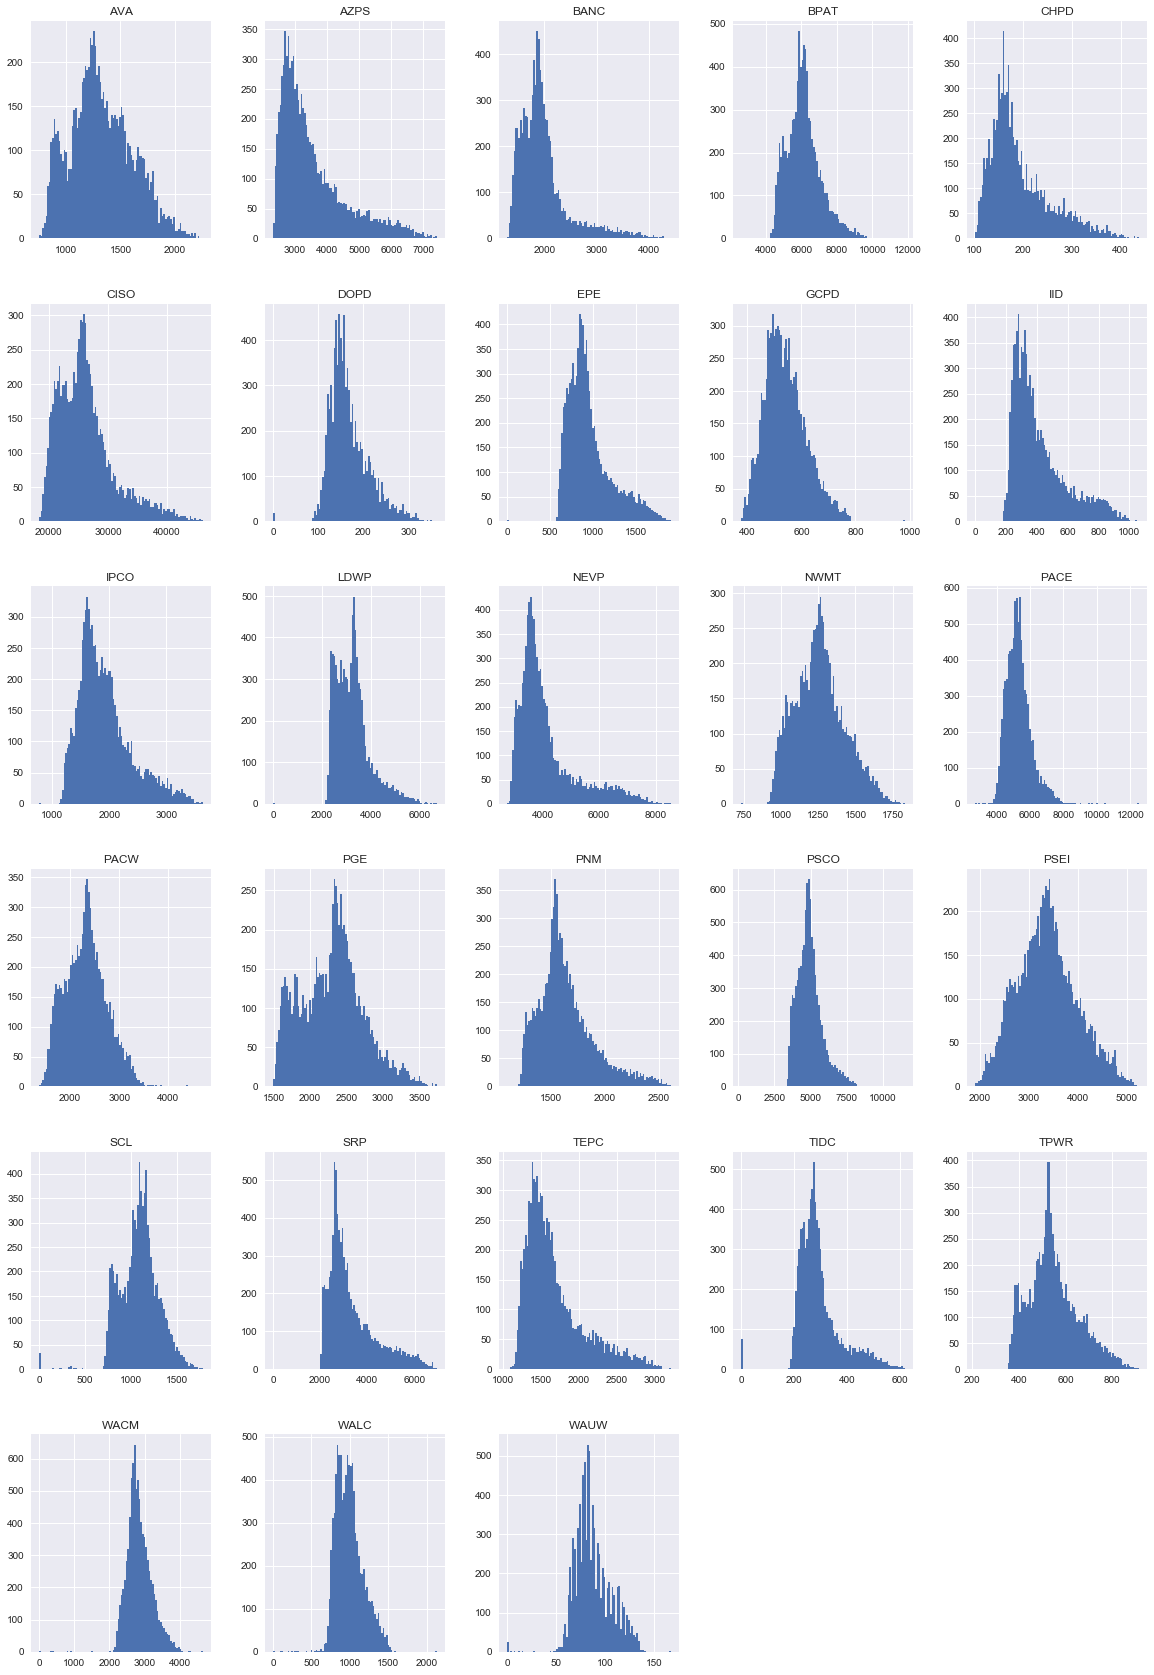

In [51]:
ba2016[['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 
       'DOPD', 'EPE', 'GCPD', 'IID',
       'IPCO', 'LDWP', 'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO',
       'PSEI', 'SCL', 'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW']].hist(bins = 100, figsize = [20,30])

In [ ]:
demand_hist = demand2016.hist(bins=100, figsize =[20,10])
plt.savefig('demand_hist.png')

In [ ]:
demand2016.index